<a href="https://colab.research.google.com/github/alanseb92/Henry--Recommendation/blob/main/Location_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Location-Based Recommendations
# Recommendation systems are widely utilized in different applications for predicting the preference or rating of a user
# in a product or service. Most likely you have come across or interacted with some type of recommender systems in the past
# few minutes or hours in your online presence.
# These Recommender systems can be of different types and the most prominent ones include Content-based filtering and Collaborative
# filtering. In this article, we will study location-based recommendations, where we specifically focus on geographic locations to render
# more relevant recommendations utilizing the location of the users.

# To illustrate the crucial aspects of location-based recommenders we will perform a simple Location-based recommendation using the
#  K-Means algorithm with Yelp Dataset

In [1]:
!pip install --upgrade geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [2]:
!pip install --upgrade pyshp

!pip install --upgrade shapely

!pip install --upgrade descartes

In [3]:
!pip install folium
!pip install plotly_express

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import folium

import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Yelp/yelp_academic_dataset_business.json', lines=True)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [7]:
df.shape

(150346, 14)

Exploratory Data Analaysis (EDA)

In [8]:
df['categories'].value_counts().head(30)

Beauty & Spas, Nail Salons                            1012
Restaurants, Pizza                                     935
Nail Salons, Beauty & Spas                             934
Pizza, Restaurants                                     823
Restaurants, Mexican                                   728
Restaurants, Chinese                                   708
Mexican, Restaurants                                   672
Chinese, Restaurants                                   651
Food, Coffee & Tea                                     508
Beauty & Spas, Hair Salons                             493
Hair Salons, Beauty & Spas                             480
Coffee & Tea, Food                                     473
Automotive, Auto Repair                                361
Auto Repair, Automotive                                351
Grocery, Food                                          329
Italian, Restaurants                                   328
Food, Grocery                                          3

In [ ]:
#Podemos utilizar todas estas categorias para examinar y utilizar el modelo de Machine Learning
#En este caso utilizaremos 'Coffee & Tea, Food'

In [ ]:
df['Coffee & Tea, Food'] = df['categories'].str.contains('Coffee & Tea, Food')
df.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,"Coffee & Tea, Food"
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,False
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",False
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",False
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",False
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",False
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",False
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...",False
7,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,FL,33707,27.766590,-82.732983,3.5,5,1,None,"Synagogues, Religious Organizations","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...",False
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,False
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",False


In [ ]:
df['Coffee & Tea, Food'].value_counts()


False    148477
True       1766
Name: Coffee & Tea, Food, dtype: int64

In [ ]:
#Como son muy pocos datos buscaremos otra palabra clave para evitar problemas de generalización

In [9]:
df['Food'] = (df['categories'].str.contains('Food'))

In [10]:
df.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Food
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,False
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",False
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",False
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True


In [11]:
df['Food'].value_counts()

False    116838
True      33405
Name: Food, dtype: int64

In [12]:
df_food = df.loc[df.Food == True]
df_food.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Food
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",True
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True


In [13]:
df_food.shape

(33405, 15)

In [14]:
top_food = df_food.sort_values(by=['review_count', 'stars'], ascending=False)[:20]
top_food.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Food
113731,_ab50qdWOk0DdB6XOrBitw,Acme Oyster House,724 Iberville St,New Orleans,LA,70130,29.954273,-90.068965,4.0,7568,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': ''fu...","Live/Raw Food, Seafood, Restaurants, Cajun/Creole","{'Monday': '11:0-22:0', 'Thursday': '11:0-22:0...",True
91757,GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville,112 19th Ave S,Nashville,TN,37203,36.151387,-86.796603,4.5,6093,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","American (Traditional), Chicken Shop, Southern...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ...",True
143157,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,51 N 12th St,Philadelphia,PA,19107,39.953341,-75.158855,4.5,5721,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Candy Stores, Shopping, Department Stores, Fas...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",True
100024,iSRTaT9WngzB8JJ2YKJUig,Mother's Restaurant,401 Poydras St,New Orleans,LA,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '...",True
113983,PP3BBaVxZLcJU54uP_wL6Q,Pat's King of Steaks,1237 E Passyunk Ave,Philadelphia,PA,19147,39.933201,-75.159266,3.0,4250,1,"{'RestaurantsReservations': 'False', 'Corkage'...","Italian, American (Traditional), Sandwiches, F...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",True


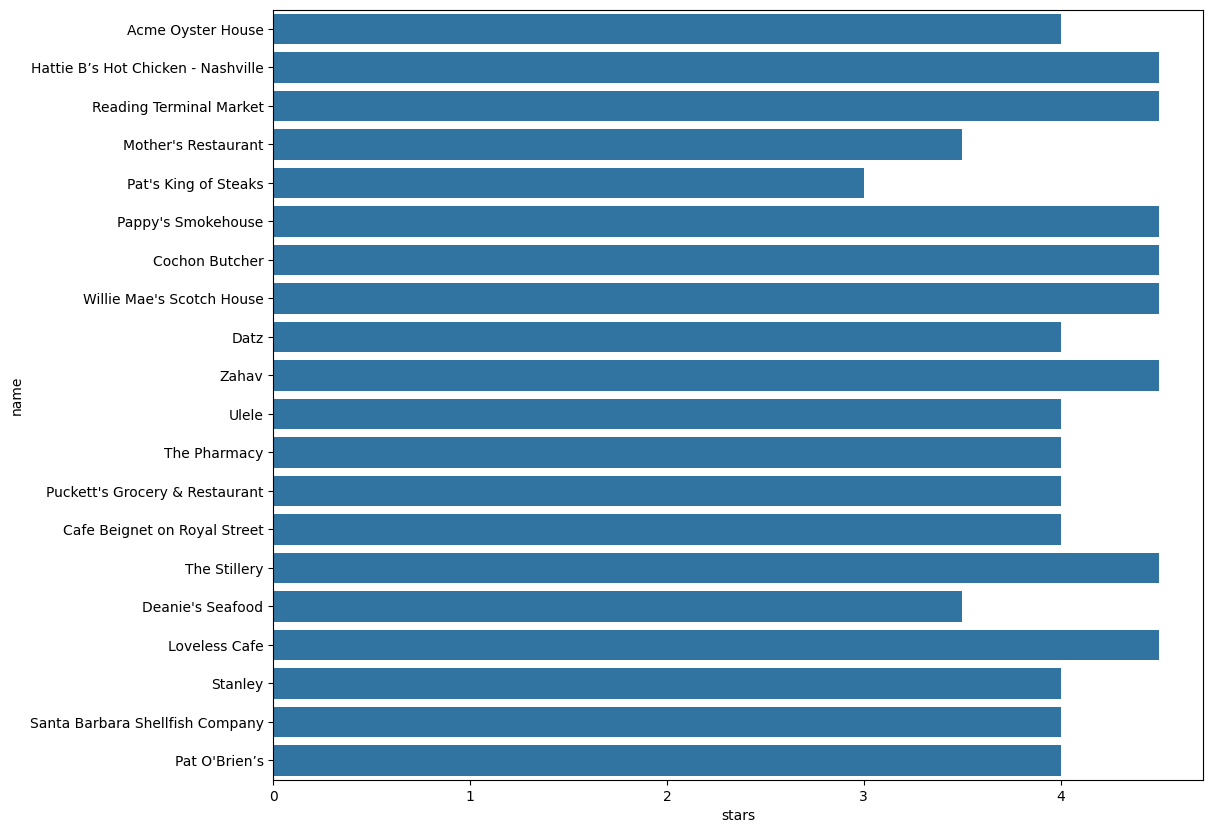

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'stars', y = 'name', data=top_food, ax= ax);
#plt.savefig('top20_Food.png')
plt.show()

In [16]:
!pip install plotly.express

In [17]:
florida = df_food[df_food.state == 'FL']

In [18]:
fig = px.scatter_mapbox(florida, lat="latitude", lon="longitude", color_discrete_sequence=["fuchsia"], zoom=10, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [28]:
import plotly.express as px

fig = px.scatter_mapbox(florida, lat="latitude", lon="longitude", color_discrete_sequence=["fuchsia"], zoom=11, height=500)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#K-Means Clustering

Determing the number of clusters (K)

In [29]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = florida[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k, n_init=10)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

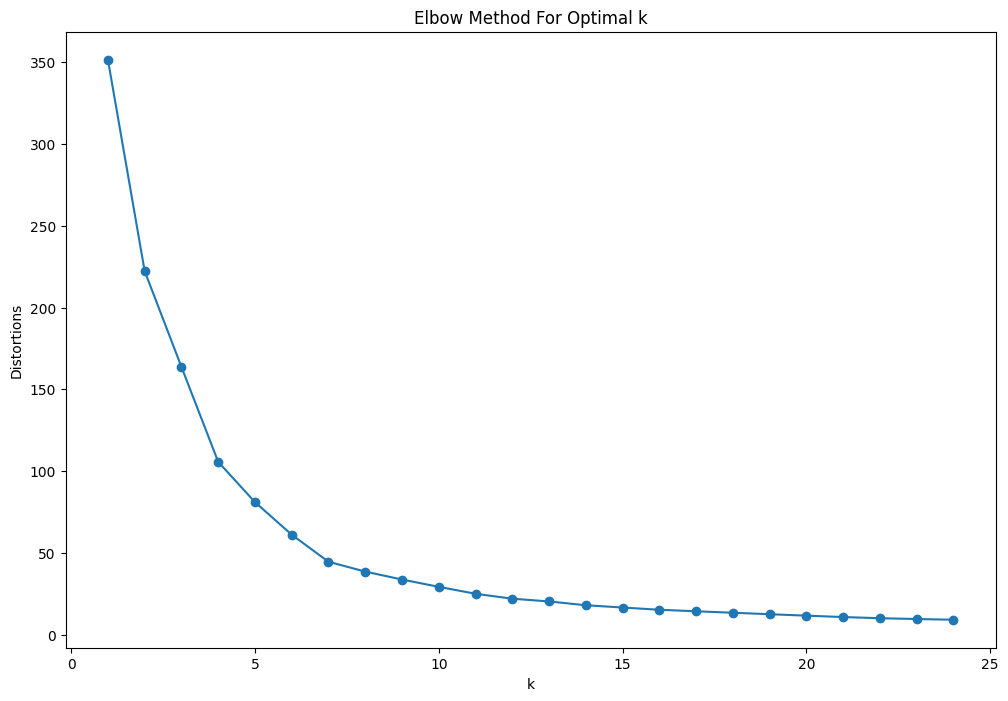

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
# plt.savefig('elbow.png')
plt.show()

Silhoute method

In [31]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, n_init=10).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [32]:
sil

[0.4360366012942204,
 0.4674654753944618,
 0.46422820272311555,
 0.46333116250764245,
 0.46477548109985384,
 0.4892829179679837,
 0.4724862202734147,
 0.4569552753310373,
 0.4331374937077104,
 0.44247250351977124,
 0.4562728607219574,
 0.4687224220572158,
 0.45896755737152645,
 0.45412656104481225,
 0.45133319109160913,
 0.46531374950615034,
 0.4614823037655031,
 0.4496503418327644,
 0.45458853778283537,
 0.4359715574643481,
 0.43329672073637304,
 0.4376923006083211,
 0.427114467293248,
 0.43639498316445147,
 0.43537348372808554,
 0.4403708447023046,
 0.4442329650620369,
 0.4433913571149004,
 0.4354732757814528,
 0.44274044673113644,
 0.4466034129916755,
 0.4406307051125808,
 0.44324835324363987,
 0.43862442087943004,
 0.4573995395629433,
 0.4495172199775779,
 0.4546841508846148,
 0.44340767559228556,
 0.45615061972062954,
 0.44672024007062305,
 0.45828895930102,
 0.44699630611399266,
 0.45099776240628947,
 0.4515302976489826,
 0.46102323511229004,
 0.4555377580183439,
 0.4584590204311

K-Means Clustering

In [55]:
kmeans = KMeans(n_clusters=5, n_init=10)
kmeans.fit(coords)
y = kmeans.labels_
print("k = 5", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 5  silhouette_score  0.4638055819797218


In [56]:
florida['cluster'] = kmeans.predict(florida[['longitude','latitude']])
florida.head()

<ipython-input-56-8186f93f098c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Food,cluster
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True,0
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'...",True,3
54,0qNpTGTcqPwOLi2hADx4Xw,Charlie's Market,2815 E Sligh Ave,Tampa,FL,33610,28.010360,-82.430042,3.0,9,1,"{'BusinessParking': '{'garage': False, 'street...","Food, Grocery, Convenience Stores",None,True,0
69,KWA2qtdwVEkMpd5soSKaGA,Publix Super Market,12101 Little Rd,Hudson,FL,34667,28.332601,-82.668107,3.5,7,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Food, Grocery",None,True,1
93,RK6-cJ9hj53RzOlCBmpT-g,Impasto,,Tampa,FL,33611,27.890814,-82.502346,5.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Italian, Food Trucks, Food","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",True,0


In [35]:

fig = px.scatter_mapbox(florida, lat="latitude", lon="longitude", color="cluster", size='review_count', hover_data= ['name', 'latitude', 'longitude'], zoom=10, height=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

#Location-Based Recommendation

In [57]:
top_food_florida = florida.sort_values(by=['review_count', 'stars'], ascending=False)
top_food_florida.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Food,cluster
137449,QHWYlmVbLC3K6eglWoHVvA,Datz,2616 S MacDill Ave,Tampa,FL,33629,27.921942,-82.493253,4.0,3260,1,"{'RestaurantsAttire': 'u'casual'', 'BusinessAc...","Burgers, Bars, Restaurants, American (Traditio...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-22:0', '...",True,0
117197,L5LLN0RafiV1Z9cddzvuCw,Ulele,1810 N Highland Ave,Tampa,FL,33602,27.960161,-82.462530,4.0,3064,1,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...","Breweries, Food, American (New), Beer, Wine & ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True,0
121653,p_qSQwShIgQnNxGcajI4-w,Oxford Exchange,420 W Kennedy Blvd,Tampa,FL,33606,27.945114,-82.464621,4.5,1868,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, American (New), Coffee & Tea, Boo...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",True,0
18273,fCDMLD21ypv1XZ_EyafCkQ,Bodega,1180 Central Ave,Saint Petersburg,FL,33705,27.770829,-82.650834,4.5,1772,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Spanish, Cafes, Cuban, Latin American, Juice B...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",True,3
7801,2KIDQyTh-HzLxOUEDqtDBg,Mazzaro's Italian Market,2909 22nd Ave N,Saint Petersburg,FL,33713,27.792256,-82.673539,4.5,1551,1,"{'BikeParking': 'True', 'RestaurantsReservatio...","Specialty Food, Delis, Coffee Roasteries, Butc...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...",True,3


In [48]:
# prompt:  Predict the cluster for longitude and latitude provided and get the best five business in this cluster



In [58]:
def recommend_food(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)

    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude'	]]

In [59]:
recommend_food(top_food_florida, 27.93301197411463, -82.28729252134539)

4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude
20675,Ford's Garage,27.922659,-82.326205
83313,Portillo's Hot Dogs,27.938192,-82.311834
48132,Tibby's New Orleans Kitchen,27.937090,-82.311333
130891,Fred's Market,27.886441,-82.330733
79213,Moreno Bakery,27.936140,-82.295040


In [ ]:
# 1 (27.947454770423267, -82.4578946047026)
# 2 (27.933090497518748, -82.28732781850161)
# 3  (28.149171613918483, -82.75678022810975)

In [60]:
test_coordinates = {
    'user': [1, 2, 3],
    'latitude' : [27.947454770423267, 27.933090497518748, 28.149171613918483],
    'longitude' : [ -82.4578946047026, -82.28732781850161,  -82.75678022810975],
}

test_df = pd.DataFrame(test_coordinates)
test_df

,user,latitude,longitude
0,1,27.947455,-82.457895
1,2,27.933090,-82.287328
2,3,28.149172,-82.756780


In [61]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,27.947455,-82.457895


In [78]:
ig = px.scatter_mapbox(recommend_food(florida, user1.longitude, user1.latitude), lat="latitude", lon="longitude",
                   zoom=10, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 10)))

0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

